# Summary

What I demonstrate here is nothing too exciting. I read in data, compute some summary statistics and 
generate a few plots. The plots do look cool though! 

This code is posted in partial satisfaction for the `startup.ml` challenge. 

http://startup.ml/challenge/


## T-Drive trajectory data

Microsoft has made available GPS data from 10,357 taxis in  Beijing. 
Each taxi's location is sampled every 177 seconds on average and we're given a week's worth of data.

http://research.microsoft.com/apps/pubs/?id=152883

The data are given in .txt files in the following format

Taxi Id (integer), Date time, Longitude (degrees), Latitude (degrees)

`1.txt:`

````
1,2008-02-02 15:36:08,116.51172,39.92123
1,2008-02-02 15:46:08,116.51135,39.93883
1,2008-02-02 15:46:08,116.51135,39.93883
````




## Reference Publications

1. Jing Yuan, Yu Zheng, Xing Xie, and Guangzhong Sun. Driving with knowledge
from the physical world. In The 17th ACM SIGKDD international conference on
Knowledge Discovery and Data mining, KDD'11, New York, NY, USA, 2011. ACM.

2. Jing Yuan, Yu Zheng, Chengyang Zhang, Wenlei Xie, Xing Xie, Guangzhong Sun, and Yan Huang. T-drive: driving directions based on taxi trajectories. In Proceedings of the 18th SIGSPATIAL International Conference on Advances in
Geographic Information Systems, GIS '10, pages 99-108, New York, NY, USA,2010.


In [1]:
from pykalman import KalmanFilter
import pandas as pd
import numpy as np
import os 
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Patch to remove log values from the colorbar on the hexbin plot
from matplotlib.ticker import LogFormatter 
class LogFormatterHB(LogFormatter):
     def __call__(self, v, pos=None):
         vv = self._base ** v
         return LogFormatter.__call__(self, vv, pos) 

# Haversine formula 
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    
    Most lat/lon points are closely spaced. Can implement small angle approx 
    to improve speed.
    """
    
    # Convert from degrees to radians
    lon1 *= np.pi/180  
    lon2 *= np.pi/180
    lat1 *= np.pi/180
    lat2 *= np.pi/180    
    
    # Haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a)) 
    r = 6371  # Radius of earth in kilometers. Use 3956 for miles
    return c * r * 1000     # convert to meters


# Function to return an array of files in a given directory
def get_files(direc):
    for root, dirs, files in os.walk(direc):
        files = files
        
    full_files = []    
    for fi in files:
        full_files.append(os.path.join(root, fi))
        
    return full_files

## Read in the data 

The data folders are stored in the `data` folder. Each `.txt` file contains the tracking data for one taxi. 

In [3]:
#%% Read in the data 
print "Reading in the .txt files..."
full_files = get_files('data')
frames = []
for index, file_path in enumerate(full_files):
    data = pd.read_csv(file_path, infer_datetime_format=True,\
            header=None, parse_dates = [1],\
            names = ['taxi_id', 'date_time', 'longitude', 'latitude'])
    frames.append(data)

data = pd.concat(frames)
del frames, index

grouped = data.groupby('taxi_id')['date_time']

Reading in the .txt files...


In [4]:
#%% Compute Time Intervals
print "Computing time intervals..."
times = []
for g in grouped:
    times.append(g[1].diff())
    
time_diffs = pd.Series()
time_diffs = pd.concat(times)
time_diffs /= np.timedelta64(1,'s') # Divide by 1 second, for float64 data

time_diffs.dropna()
time_diffs /= 60    # Convert to minutes

#print "Average sample interval: %.1f secs" % time_diffs.mean()*60


Computing time intervals...
Average sample interval: 5.5 secsAverage sample interval: 5.5 secsAverage sample interval: 5.5 secsAverage sample interval: 5.5 secsAverage sample interval: 5.5 secsAverage sample interval: 5.5 secsAverage sample interval: 5.5 secsAverage sample interval: 5.5 secsAverage sample interval: 5.5 secsAverage sample interval: 5.5 secsAverage sample interval: 5.5 secsAverage sample interval: 5.5 secsAverage sample interval: 5.5 secsAverage sample interval: 5.5 secsAverage sample interval: 5.5 secsAverage sample interval: 5.5 secsAverage sample interval: 5.5 secsAverage sample interval: 5.5 secsAverage sample interval: 5.5 secsAverage sample interval: 5.5 secsAverage sample interval: 5.5 secsAverage sample interval: 5.5 secsAverage sample interval: 5.5 secsAverage sample interval: 5.5 secsAverage sample interval: 5.5 secsAverage sample interval: 5.5 secsAverage sample interval: 5.5 secsAverage sample interval: 5.5 secsAverage sample interval: 5.5 secsAverage sample 

In [5]:
#%% Compute Distance Intervals
print "Computing distance intervals..."
lon1 = np.array(data.longitude[0:-2])
lon2 = np.array(data.longitude[1:-1])
lat1 = np.array(data.latitude[0:-2])
lat2 = np.array(data.latitude[1:-1])

distances = haversine(lon1, lat1, lon2, lat2)

Computing distance intervals...


Plotting time intervals...


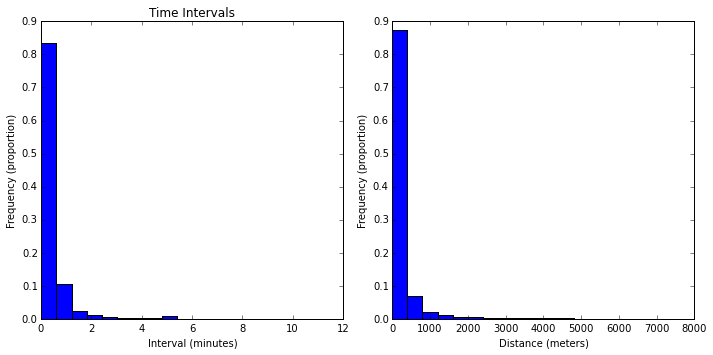

In [6]:
#%% Plotting: Time -- plots a histogram time intervals with 
#                     proportions summing to 1
print "Plotting time intervals..."
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
#fig = plt.figure(figsize = (8,4))
#fig.set_figure_width(6)
axes[0].set_xlabel('Interval (minutes)')
axes[0].set_ylabel('Frequency (proportion)')
axes[0].set_title('Time Intervals')

hist, bins = np.histogram(time_diffs[(time_diffs > 0) & \
            (time_diffs < 12)].astype(np.ndarray), bins=20)
axes[0].bar(bins[:-1], hist.astype(np.float32) / hist.sum(), width=(bins[1]-bins[0]))

#% Plotting: Distance -- plots a normed histogram of distance intervals
distances = pd.Series(distances)
distances.dropna(inplace=True)

hist, bins = np.histogram(distances[(distances > 0) & \
            (distances < 8000)].astype(np.ndarray), bins=20)
axes[1].bar(bins[:-1], hist.astype(np.float32) / hist.sum(), width=(bins[1]-bins[0]))
axes[1].set_xlabel('Distance (meters)')
axes[1].set_ylabel('Frequency (proportion)')

fig.tight_layout()

Plotting position density...


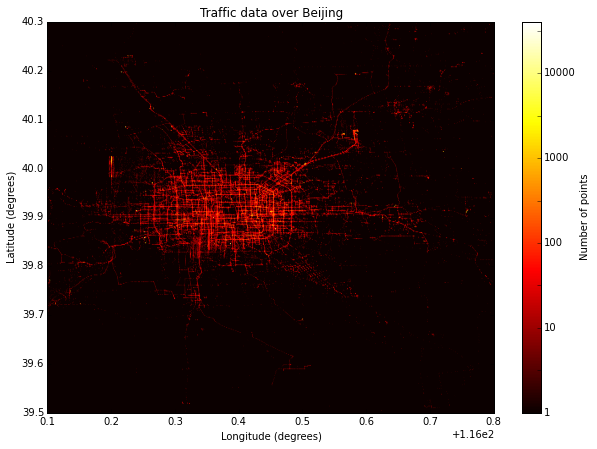

In [7]:
#%% Plot position density 
print "Plotting position density..."
xmin = 116.1
xmax = 116.8
ymin = 39.5
ymax = 40.3

window = data[(xmin < data.longitude) & (data.longitude < xmax) & \
            (ymin < data.latitude) & ( data.latitude < ymax)]

x = np.array(window.longitude)
y = np.array(window.latitude)

plt.figure(figsize = (10,7), dpi=200)
plt.hexbin(x,y,bins='log', gridsize=800, cmap=plt.cm.hot)   # black -> red > white
plt.axis([xmin, xmax, ymin, ymax])
plt.title("Traffic data over Beijing")
plt.xlabel('Longitude (degrees)')
plt.ylabel('Latitude (degrees)')

cb = plt.colorbar(format=LogFormatterHB())
cb.set_label('Number of points')

plt.show()


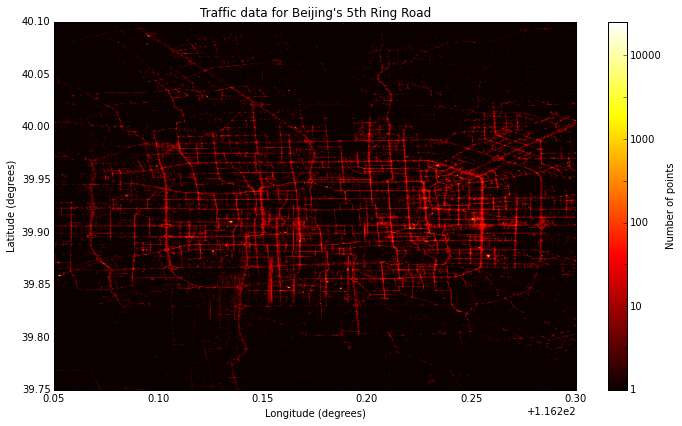

In [8]:
#%% Make the 5th Ring Road Beijing

# Location details
xmin, xmax = 116.25, 116.5
ymin, ymax = 39.75, 40.1

window = data[(xmin < data.longitude) & (data.longitude < xmax) & \
            (ymin < data.latitude) & ( data.latitude < ymax)]

x = np.array(window.longitude)
y = np.array(window.latitude)

plt.figure(figsize = (10,6), dpi=150)
plt.hexbin(x,y, bins='log', gridsize=800, cmap=plt.cm.hot)   # black -> red > white
plt.axis([xmin, xmax, ymin, ymax])
plt.title("Traffic data for Beijing's 5th Ring Road")
plt.xlabel('Longitude (degrees)')
plt.ylabel('Latitude (degrees)')

cb = plt.colorbar(format=LogFormatterHB())
cb.set_label('Number of points')

plt.tight_layout()
plt.show()

Taxi data for Taxi ID:  2172
Start date and time:  2008-02-02 16:16:50
Duration : 0 days 03:19:08


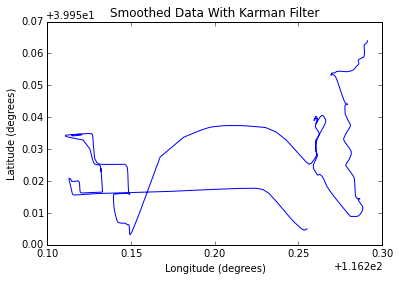

In [10]:
#%% Kalman Filter and plot results

#kf = KalmanFilter(transition_matrices = [[1, 1], [0, 1]], observation_matrices = [[0.1, 0.5], [-0.3, 0.0]])
#kf = KalmanFilter(transition_matrices = [[1, 0], [0, 1]], observation_matrices = [[0.1, 0.5], [-0.3, 0.0]], n_dim_obs=2, n_dim_state=2)

#%% Select data for one taxi
one_taxi = data[data.taxi_id == 2172]

measurements = np.asarray([one_taxi.longitude, one_taxi.latitude])
measurements = measurements.T[0:400]
kf = KalmanFilter(initial_state_mean = measurements[0], \
           n_dim_obs=2, n_dim_state=2)


kf = kf.em(measurements)
#(filtered_state_means, filtered_state_covariances) = kf.filter(measurements)
(smoothed_state_means, smoothed_state_covariances) = kf.smooth(measurements)

#plt.plot(filtered_state_means.T[0],filtered_state_means.T[1])
plt.plot(smoothed_state_means.T[0],smoothed_state_means.T[1])
plt.title("Smoothed Data With Karman Filter")
plt.xlabel('Longitude (degrees)')
plt.ylabel('Latitude (degrees)')
print "Taxi data for Taxi ID: ", 2172
print "Start date and time: ", one_taxi.date_time[0]
print "Duration :", one_taxi.date_time[400] - one_taxi.date_time[0]
plt.figure()
#plt.plot(measurements.T[0],measurements.T[1])